In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import tensorflow as tf



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


seed_value = 42

np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

os.environ['PYTHONHASHSEED'] = str(seed_value)

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sklearn
from sklearn.metrics import confusion_matrix

In [3]:
import sys
print("Python version:", sys.version)

print("Library Versions:")
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Keras version:", keras.__version__)
print("OS version:", os.__name__)

Python version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Library Versions:
Numpy version: 1.26.4
Pandas version: 2.2.2
TensorFlow version: 2.17.0
SciPy version: 1.13.1
Scikit-learn version: 1.5.2
Matplotlib version: 3.8.0
Keras version: 3.4.1
OS version: os


In [4]:
import kagglehub

# Step 1: Download the dataset using kagglehub
path = kagglehub.dataset_download("syamkakarla/pavia-university-hsi")
print("Dataset downloaded to:", path)

c:\Users\msı\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\msı\.cache\kagglehub\datasets\syamkakarla\pavia-university-hsi\versions\1


In [5]:
pavia_university_path="C:/Users/msı/.cache/kagglehub/datasets/syamkakarla/pavia-university-hsi/versions/1/PaviaU.mat"
pavia_university_gt_path="C:/Users/msı/.cache/kagglehub/datasets/syamkakarla/pavia-university-hsi/versions/1/PaviaU_gt.mat"

pavia_university_data = sio.loadmat(pavia_university_path)['paviaU']
pavia_university_gt = sio.loadmat(pavia_university_gt_path)['paviaU_gt']

In [6]:
import shutil

working_dir = "/kaggle/working"

# Remove all files and subdirectories in the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove files and symlinks
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

print("kaggle/working directory has been reset.")

kaggle/working directory has been reset.


In [7]:
print("Pavia University data shape:", pavia_university_data.shape)
print("Pavia University ground truth shape:", pavia_university_gt.shape)

Pavia University data shape: (610, 340, 103)
Pavia University ground truth shape: (610, 340)


In [8]:
def get_dataset_info(dataset_name, dataset, ground_truth):
    print(f"Dataset: {dataset_name}")
    print(f"Dimensions (width, height, bands): {dataset.shape}")
    print(f"Number of Bands: {dataset.shape[2]}")
    print(f"Ground Truth Classes: {np.unique(ground_truth)}")
    print()

get_dataset_info("Pavia University", pavia_university_data, pavia_university_gt)

Dataset: Pavia University
Dimensions (width, height, bands): (610, 340, 103)
Number of Bands: 103
Ground Truth Classes: [0 1 2 3 4 5 6 7 8 9]



In [9]:
pavia_center_path="C:/Users/msı/OneDrive/Masaüstü/bitirme/Grad_project/paviaC.mat"
pavia_center_gt_path="C:/Users/msı/OneDrive/Masaüstü/bitirme/Grad_project/paviaC_7gt.mat"

pavia_center_data = sio.loadmat(pavia_center_path)
print(pavia_center_data.keys())

pavia_center_data = sio.loadmat(pavia_center_path)['ori_data']
pavia_center_gt = sio.loadmat(pavia_center_gt_path)['map']

dict_keys(['__header__', '__version__', '__globals__', 'ori_data'])


In [10]:
datasets = [(pavia_university_data, pavia_university_gt, "Pavia University"),
            (pavia_center_data, pavia_center_gt, "Pavia Center")]

In [11]:
for X, y, dataset_name in datasets:
    print(f"Dataset: {dataset_name}")
    # Get unique class names based on ground truth labels for the current dataset
    class_names = np.unique(y)
    # Calculate the number of samples for each class
    summary = pd.DataFrame([{'class_name': label, 'samples': np.sum(y == val)} for val, label in enumerate(class_names)])
    print(summary)
    print()

Dataset: Pavia University
   class_name  samples
0           0   164624
1           1     6631
2           2    18649
3           3     2099
4           4     3064
5           5     1345
6           6     5029
7           7     1330
8           8     3682
9           9      947

Dataset: Pavia Center
   class_name  samples
0           0   744285
1           1     7598
2           2     9248
3           3     2685
4           4     7287
5           5     2863
6           6     3090
7           7     6584



In [12]:
pavia_university_classes = {
    1: 'Asphalt',
    2: 'Meadows',
    3: 'Gravel',
    4: 'Trees',
    5: 'Painted metal sheets',
    6: 'Bare soil',
    7: 'Bitumen',
    8: 'Self-Blocking Bricks',
    9: 'Shadows'
}

pavia_center_classes = {
    1: 'Trees',
    2: 'Asphalt',
    3: 'Self-blocking bricks',
    4: 'Bitumen',
    5: 'Shadows',
    6: 'Meadows',
    7: 'Bare Soil'
}

def map_labels(y, class_mapping):

    unique_labels, counts = np.unique(y, return_counts=True)
    mapped_classes = [
        {'Class ID': label, 'Class Name': class_mapping.get(label, 'Unknown'), 'Samples': count}
        for label, count in zip(unique_labels, counts)
    ]
    return pd.DataFrame(mapped_classes)

center_mapping = map_labels(pavia_center_gt, pavia_center_classes)
university_mapping = map_labels(pavia_university_gt, pavia_university_classes)

print(f"{center_mapping}")
print(f"{university_mapping}")


   Class ID            Class Name  Samples
0         0               Unknown   744285
1         1                 Trees     7598
2         2               Asphalt     9248
3         3  Self-blocking bricks     2685
4         4               Bitumen     7287
5         5               Shadows     2863
6         6               Meadows     3090
7         7             Bare Soil     6584
   Class ID            Class Name  Samples
0         0               Unknown   164624
1         1               Asphalt     6631
2         2               Meadows    18649
3         3                Gravel     2099
4         4                 Trees     3064
5         5  Painted metal sheets     1345
6         6             Bare soil     5029
7         7               Bitumen     1330
8         8  Self-Blocking Bricks     3682
9         9               Shadows      947


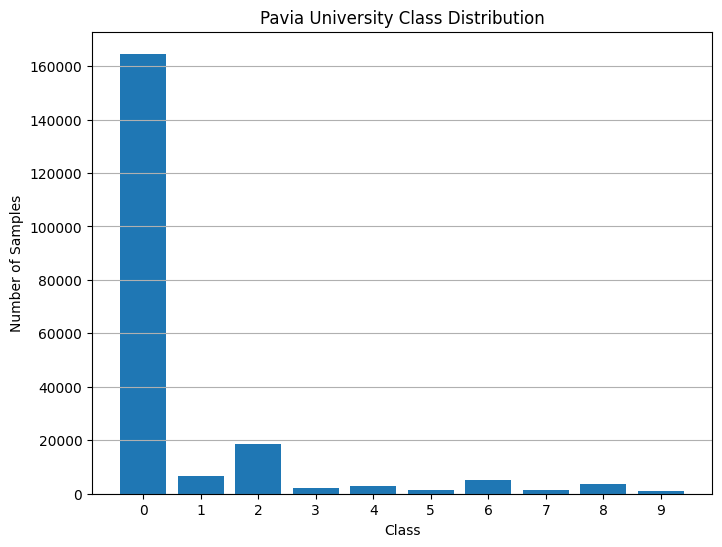

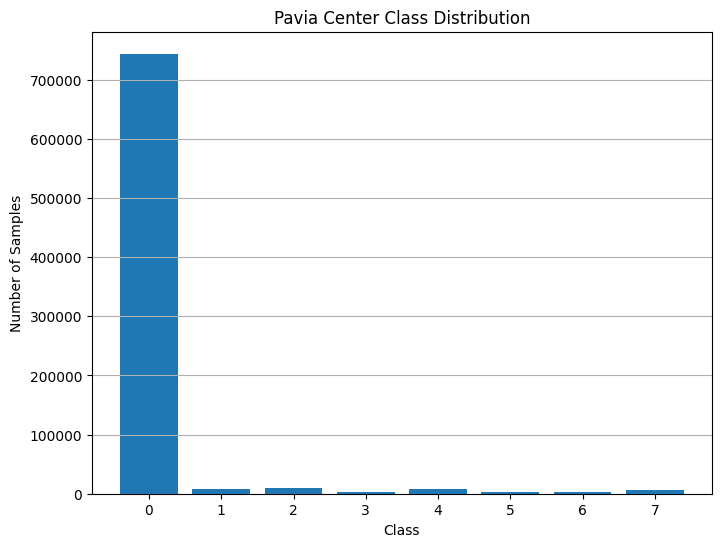

In [13]:
import matplotlib.pyplot as plt

def plot_class_distribution(data, ground_truth, dataset_name):
    # Compute unique classes and their counts
    unique_classes, class_counts = np.unique(ground_truth, return_counts=True)

    # Plot class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(unique_classes, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'{dataset_name} Class Distribution')
    plt.xticks(unique_classes)
    plt.grid(axis='y')
    plt.show()

for data, ground_truth, name in datasets:
    plot_class_distribution(data, ground_truth, name)


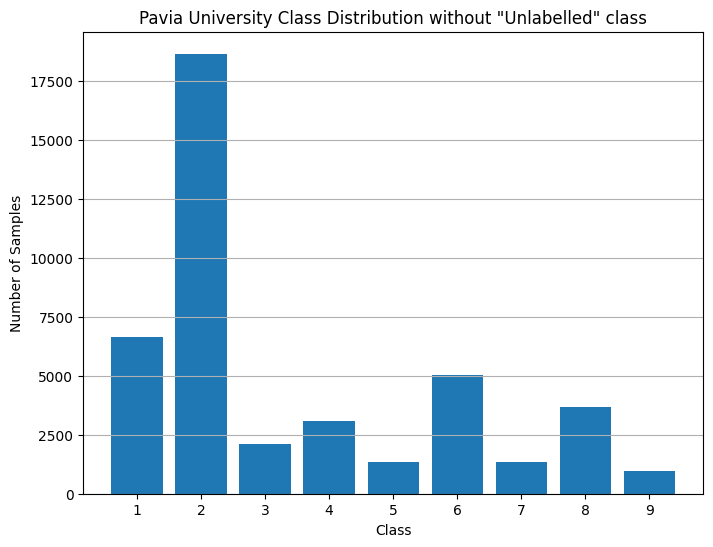

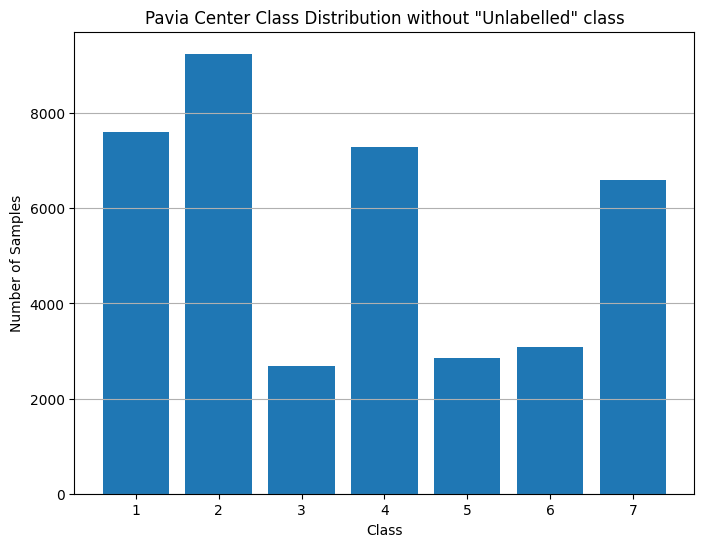

In [14]:
def plot_class_distribution(data, ground_truth, dataset_name):
    # Compute unique classes and their counts, excluding label 0
    unique_classes, class_counts = np.unique(ground_truth, return_counts=True)

    # Exclude label 0 from unique_classes and class_counts
    mask = unique_classes != 0
    unique_classes = unique_classes[mask]
    class_counts = class_counts[mask]

    # Plot class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(unique_classes, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'{dataset_name} Class Distribution without "Unlabelled" class')
    plt.xticks(unique_classes)
    plt.grid(axis='y')
    plt.show()

for data, ground_truth, name in datasets:
    plot_class_distribution(data, ground_truth, name)

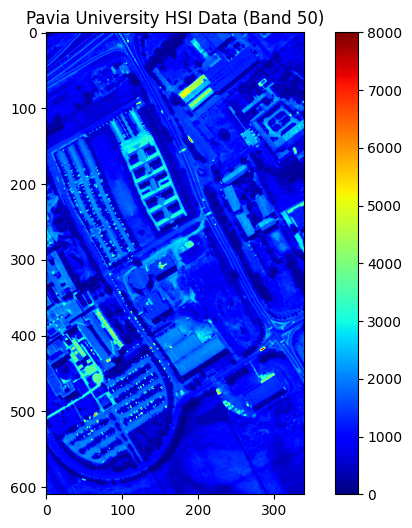

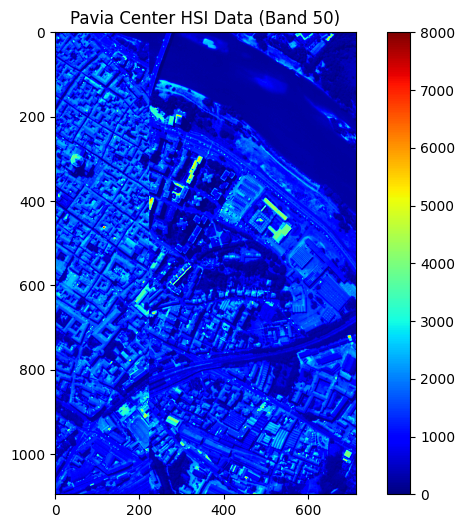

In [15]:
def plot_band(data, band_number, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(data[:, :, band_number], cmap='jet')
    plt.title(f'{dataset_name} HSI Data (Band {band_number})')
    plt.colorbar()
    plt.show()

for data, ground_truth, name in datasets:
    plot_band(data, 50, name)

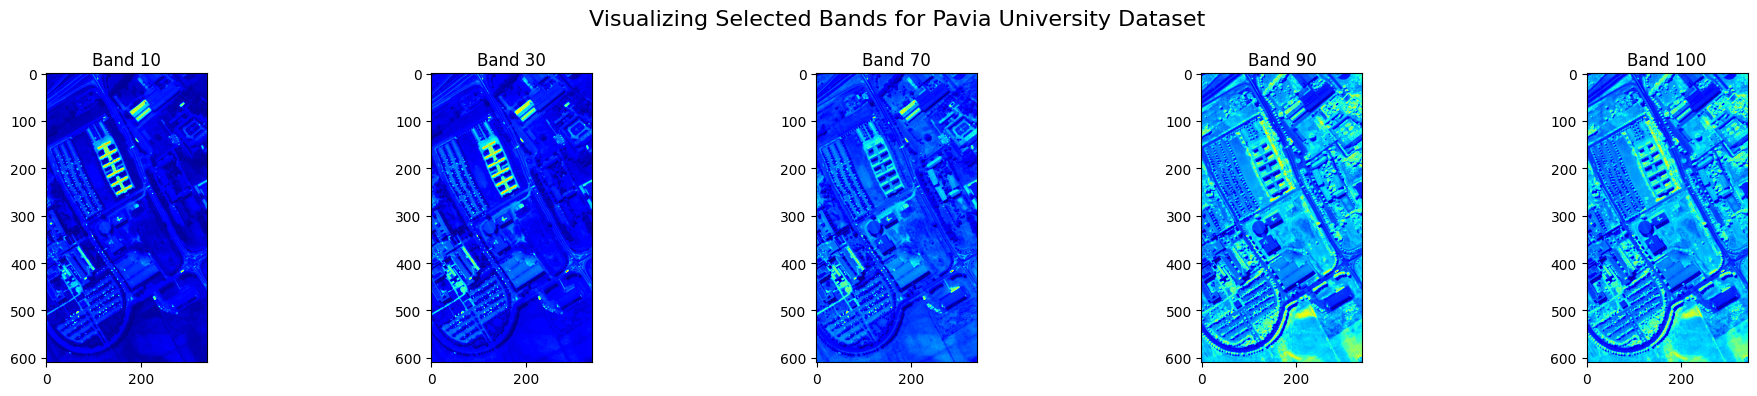

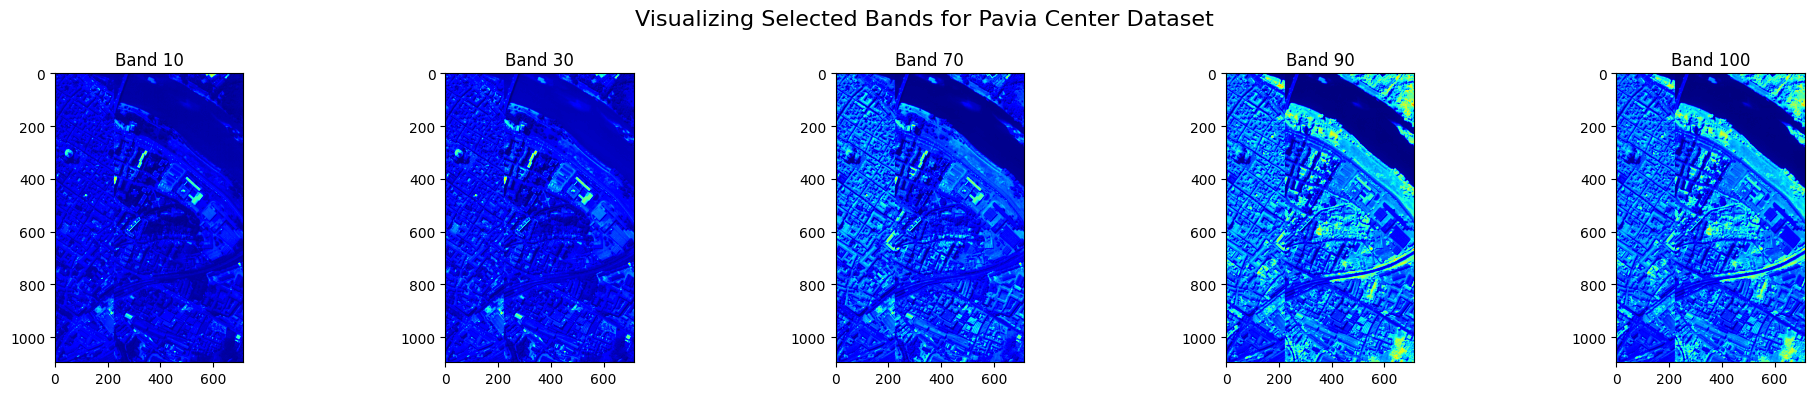

In [16]:
def visualize_selected_bands(dataset_name, dataset, band_indices):
    num_bands_to_visualize = len(band_indices)
    num_plots = num_bands_to_visualize // 5 + (1 if num_bands_to_visualize % 5 != 0 else 0)
    fig, axes = plt.subplots(num_plots, 5, figsize=(20, num_plots * 4))
    fig.suptitle(f'Visualizing Selected Bands for {dataset_name} Dataset', fontsize=16)
    if num_plots == 1:
        axes = [axes]
    for i, band_idx in enumerate(band_indices):
        row_idx = i // 5
        col_idx = i % 5
        axes[row_idx][col_idx].imshow(dataset[:,:,band_idx], cmap='jet')
        axes[row_idx][col_idx].set_title(f'Band {band_idx}')
    plt.tight_layout()
    plt.show()

pavia_university_selected_bands = [10, 30, 70, 90, 100]

visualize_selected_bands("Pavia University", pavia_university_data, pavia_university_selected_bands)
visualize_selected_bands("Pavia Center", pavia_center_data, pavia_university_selected_bands)

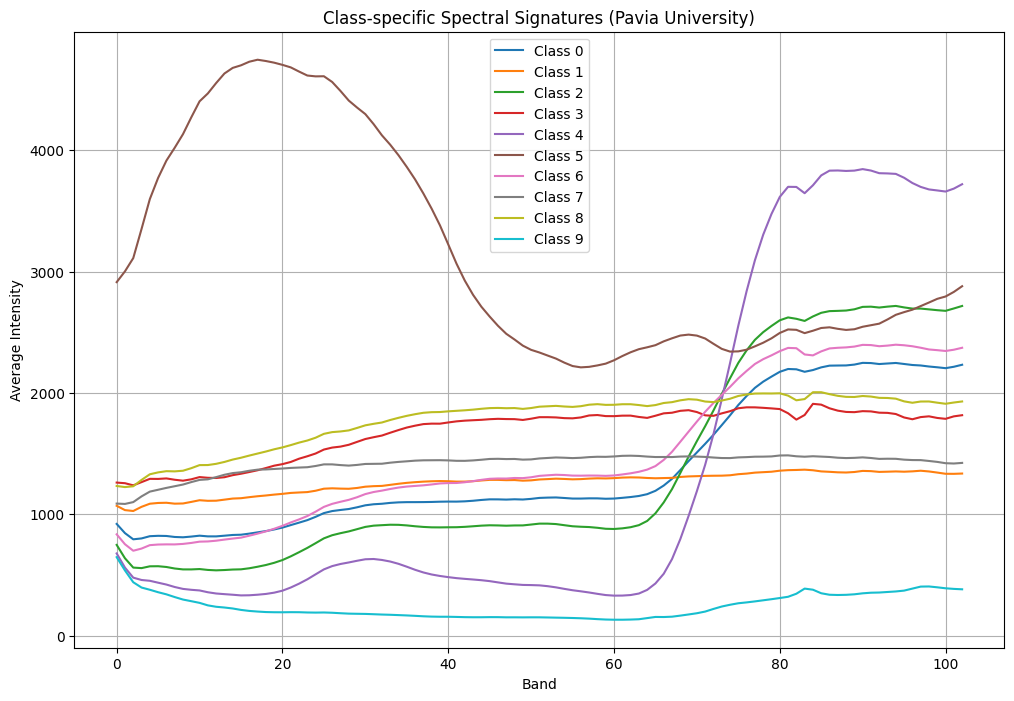

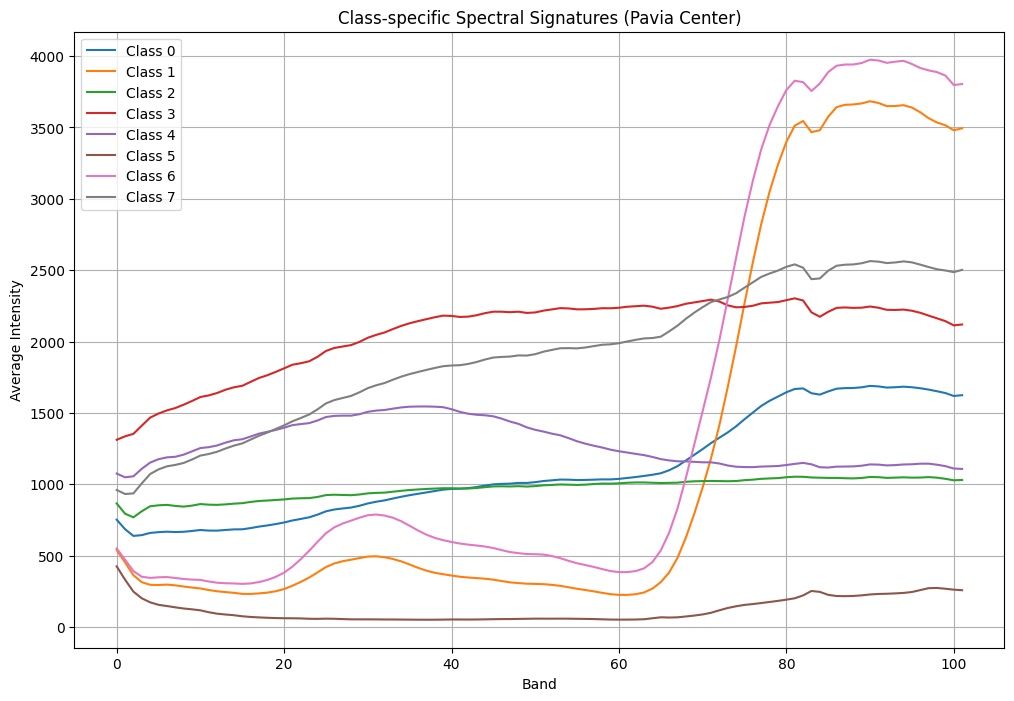

In [17]:
def plot_spectral_signatures(data, ground_truth, dataset_name):
    unique_classes = np.unique(ground_truth)
    plt.figure(figsize=(12, 8))
    for cls in unique_classes:
        cls_indices = np.where(ground_truth == cls)
        cls_samples = data[cls_indices]
        avg_spectrum = np.mean(cls_samples, axis=0)
        plt.plot(avg_spectrum, label=f'Class {cls}')
    plt.xlabel('Band')
    plt.ylabel('Average Intensity')
    plt.title(f'Class-specific Spectral Signatures ({dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.show()
for data, ground_truth, name in datasets:
    plot_spectral_signatures(data, ground_truth, name)

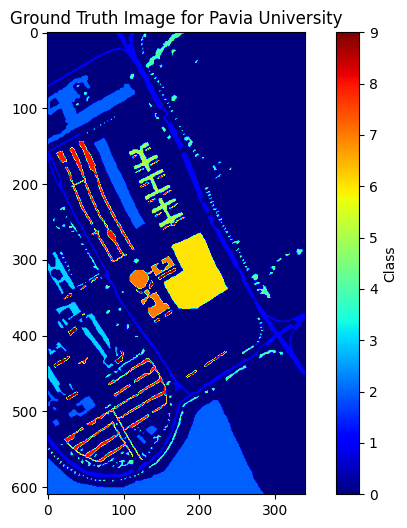

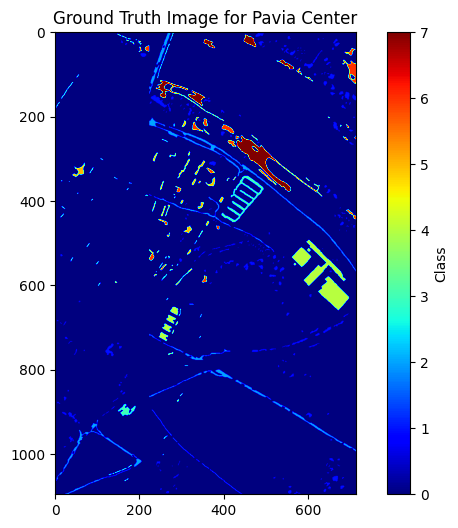

In [18]:
def visualize_ground_truth(dataset_name, ground_truth):
    plt.figure(figsize=(8, 6))
    plt.imshow(ground_truth, cmap='jet')
    plt.title(f'Ground Truth Image for {dataset_name}')
    plt.colorbar(label='Class')
    plt.show()

for dataset, ground_truth, dataset_name in datasets:
    visualize_ground_truth(dataset_name, ground_truth)

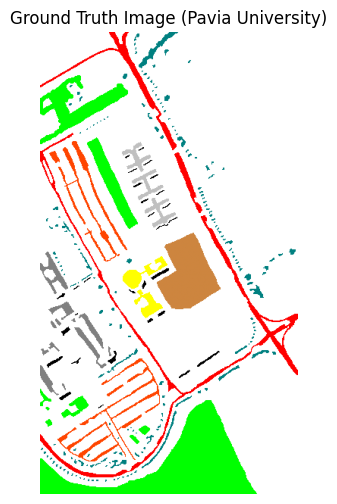

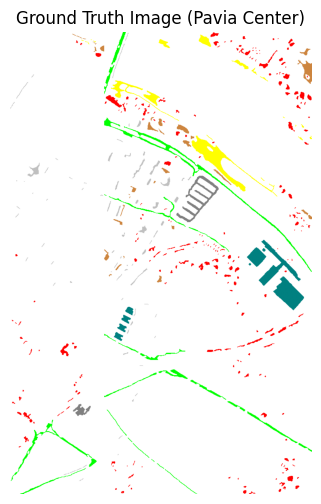

In [19]:
def plot_ground_truth(ground_truth_data, dataset_name):
    dataset_name == "Pavia University"
    class_colors = {
            0: [255, 255, 255],             # Unclassified (White)
            1: [255, 0, 0],                 # Asphalt (Red)
            2: [0, 255, 0],                 # Meadows (Green)
            3: [128, 128, 128],             # Gravel (Gray)
            4: [0, 128, 128],               # Trees (Teal)
            5: [192, 192, 192],             # Painted metal sheets (Silver)
            6: [205, 133, 63],              # Bare Soil (Brown)
            7: [255, 255, 0],               # Bitumen (Yellow)
            8: [255, 69, 0],                # Self-Blocking Bricks (Orange Red)
            9: [0, 0, 0]                    # Shadows (Black)
        }

    y = np.zeros((ground_truth_data.size, 3))
    for i, class_label in enumerate(ground_truth_data.ravel()):
        y[i] = np.array(class_colors.get(class_label, [255, 255, 255])) / 255.

    ground_truth_image = np.reshape(y, (ground_truth_data.shape[0], ground_truth_data.shape[1], 3))
    plt.figure(figsize=(8, 6))
    plt.imshow(ground_truth_image)
    plt.title(f'Ground Truth Image ({dataset_name})')
    plt.axis('off')
    plt.show()


for dataset, ground_truth, dataset_name in datasets:
    plot_ground_truth(ground_truth, dataset_name)

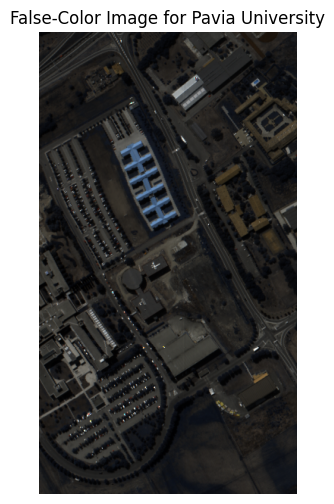

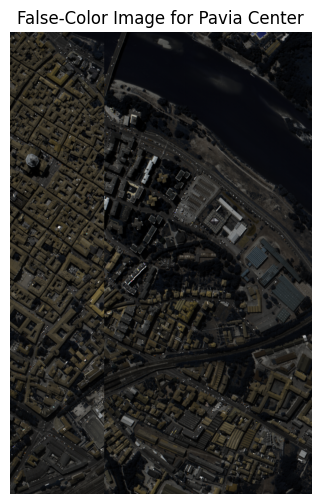

In [20]:
def create_false_color_image(dataset, bands):
    false_color_image = np.stack((dataset[:,:,bands[0]], dataset[:,:,bands[1]], dataset[:,:,bands[2]]), axis=2)
    false_color_image = (false_color_image - np.min(false_color_image)) / (np.max(false_color_image) - np.min(false_color_image))
    return false_color_image

for dataset, ground_truth, dataset_name in datasets:
    if dataset_name == "Indian Pines":
        false_color_bands = [30, 20, 10]
    elif dataset_name == "Pavia Center":
        false_color_bands = [55, 45, 35]
    elif dataset_name == "Pavia University":
        false_color_bands = [50, 40, 30]
    else:
        print(f"Unknown dataset: {dataset_name}")
        continue

    false_color_image = create_false_color_image(dataset, false_color_bands)
    plt.figure(figsize=(8, 6))
    plt.imshow(false_color_image)
    plt.title(f'False-Color Image for {dataset_name}')
    plt.axis('off')
    plt.show()


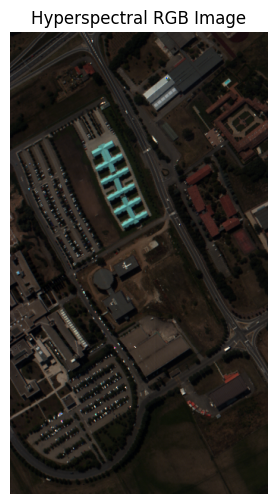

In [21]:
def plot_hyperspectral_rgb(hyperspectral_data):
    data = hyperspectral_data / 8000.
    blue = data[:, :, 10]  # blue band
    green = data[:, :, 24]  # green band
    red = data[:, :, 44]  # red band
    rgb_hsi = np.zeros((data.shape[0], data.shape[1], 3))
    rgb_hsi[:, :, 0] = red
    rgb_hsi[:, :, 1] = green
    rgb_hsi[:, :, 2] = blue
    # Normalize pixel values to [0, 1] range
    rgb_hsi = np.clip(rgb_hsi, 0, 1)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb_hsi)
    plt.title('Hyperspectral RGB Image')
    plt.axis('off')
    plt.show()

# Process and plot the hyperspectral RGB image for each dataset
for hyperspectral_data in [pavia_university_data]:
    plot_hyperspectral_rgb(hyperspectral_data)

In [22]:
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

pavia_university_normalized = normalize_data(pavia_university_data)
pavia_center_normalized = normalize_data(pavia_center_data)

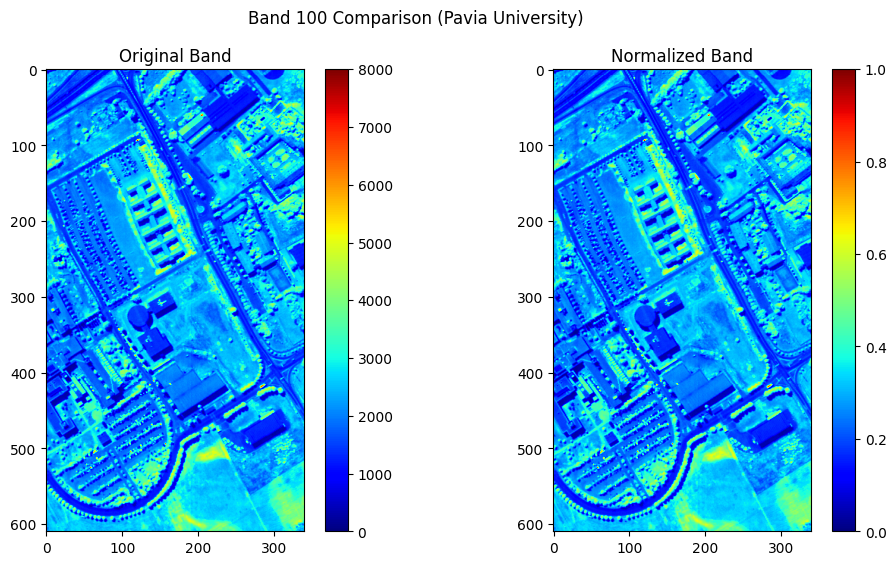

In [23]:
def plot_band_comparison(original_data, normalized_data, band_idx, dataset_name):
    original_band = original_data[:, :, band_idx]
    normalized_band = normalized_data[:, :, band_idx]

    plt.figure(figsize=(12, 6))

    # Original data
    plt.subplot(1, 2, 1)
    plt.imshow(original_band, cmap='jet')
    plt.title('Original Band')
    plt.colorbar()

    # Normalized data
    plt.subplot(1, 2, 2)
    plt.imshow(normalized_band, cmap='jet')
    plt.title('Normalized Band')
    plt.colorbar()

    plt.suptitle(f'Band {band_idx} Comparison ({dataset_name})')
    plt.show()

plot_band_comparison(pavia_university_data, pavia_university_normalized, 100, "Pavia University")

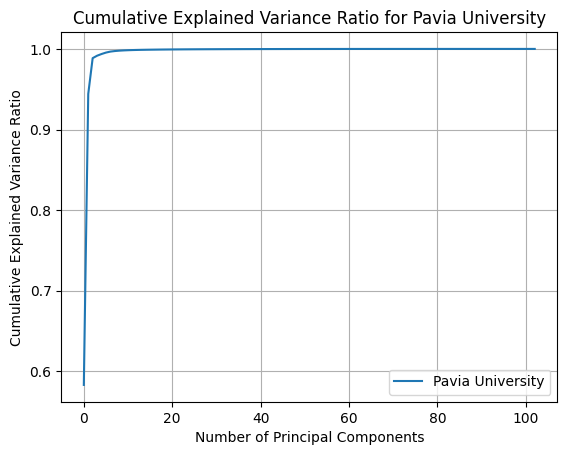

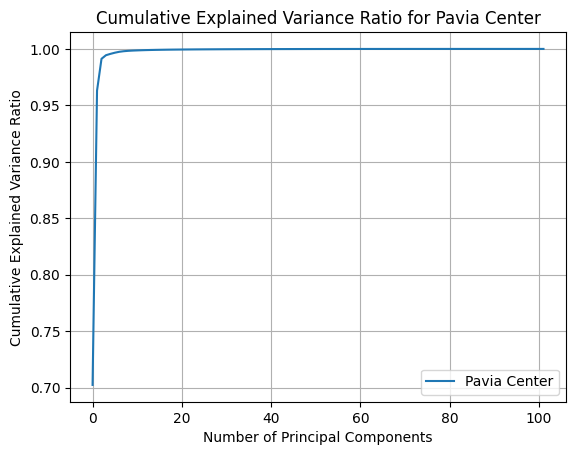

In [24]:
def plot_cumulative_variance_ratio(flattened_data, dataset_name):
    pca = PCA()
    pcX = pca.fit_transform(flattened_data)
    ev = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(ev)

    plt.plot(cumulative_var, label=dataset_name)

    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio for '+dataset_name)
    plt.legend()
    plt.grid(True)
    plt.show()

pavia_university_flattened = pavia_university_normalized.reshape(-1, pavia_university_normalized.shape[-1])
pavia_center_flattened = pavia_center_normalized.reshape(-1, pavia_center_normalized.shape[-1])

plot_cumulative_variance_ratio(pavia_university_flattened, "Pavia University")
plot_cumulative_variance_ratio(pavia_center_flattened, "Pavia Center")

In [25]:
def dimension_PCA(data, input_dimension):
    # Reshape the data into a 2D array (samples x features)
    num_samples, num_features, num_bands = data.shape
    flattened_data = data.reshape(num_samples * num_features, num_bands)

    # Apply PCA to the flattened data
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)

    # Transform the data back to the original shape
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(num_samples, num_features, input_dimension)

    return whole_pca

pavia_university_pca = dimension_PCA(pavia_university_normalized, 4)
pavia_center_pca = dimension_PCA(pavia_center_normalized, 4)

print(pavia_university_pca.shape)
print(pavia_center_pca.shape)

(610, 340, 4)
(1096, 715, 4)


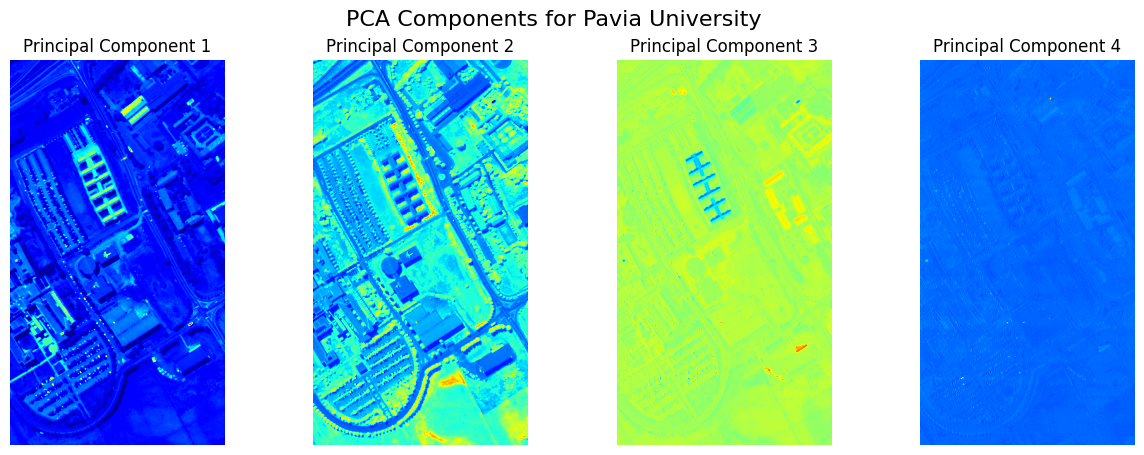

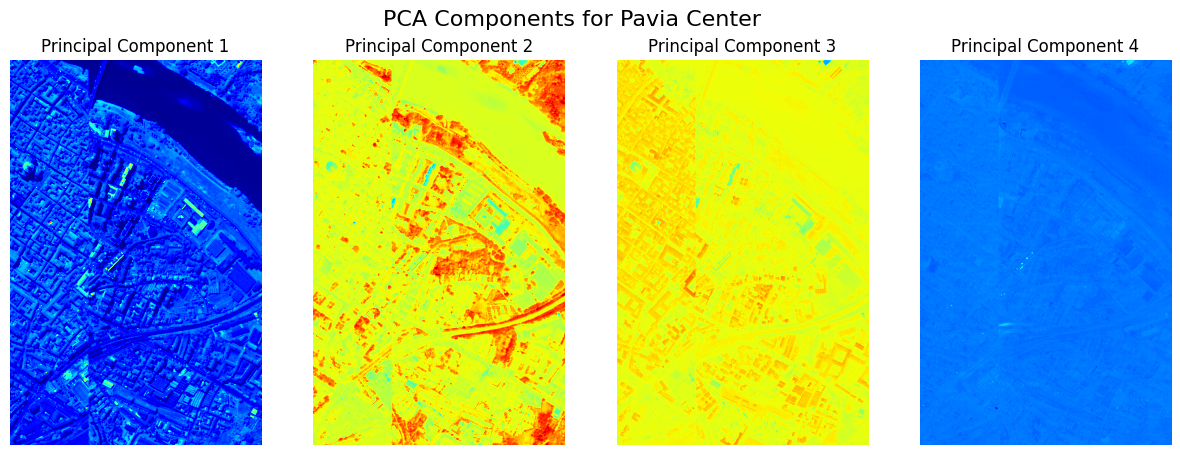

In [26]:
def plot_pca_components(pca_data, dataset_name, num_components=4):
    fig, axes = plt.subplots(1, num_components, figsize=(15, 5))
    for i in range(num_components):
        axes[i].imshow(pca_data[:, :, i], cmap='jet')
        axes[i].set_title(f'Principal Component {i+1}')
        axes[i].axis('off')
    fig.suptitle(f'PCA Components for {dataset_name}', fontsize=16)
    plt.show()

plot_pca_components(pavia_university_pca, 'Pavia University')
plot_pca_components(pavia_center_pca, 'Pavia Center')

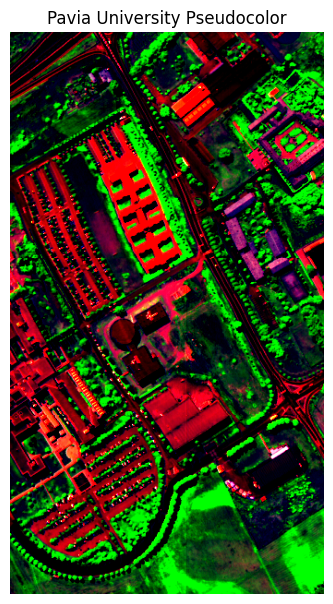

In [27]:
def create_pseudocolor_image(pca_data, bands):
    # Use selected principal components for pseudocolor visualization
    pseudocolor_image = np.stack((pca_data[:,:,bands[0]], pca_data[:,:,bands[1]], pca_data[:,:,bands[2]]), axis=2)

    # Normalize the pseudocolor image data
    pseudocolor_image = np.clip(pseudocolor_image, 0, 1)  # Ensure values are within [0, 1]

    return pseudocolor_image

# Parameters
pseudocolor_bands = [0, 1, 2]  # Bands for pseudocolor visualization

# Create pseudocolor images for each dataset
pavia_university_pseudocolor = create_pseudocolor_image(pavia_university_pca, pseudocolor_bands)

# Plot pseudocolor images for each dataset
plt.figure(figsize=(10, 8))

plt.subplot(133)
plt.imshow(pavia_university_pseudocolor)
plt.title('Pavia University Pseudocolor')
plt.axis('off')

plt.tight_layout()
plt.show()

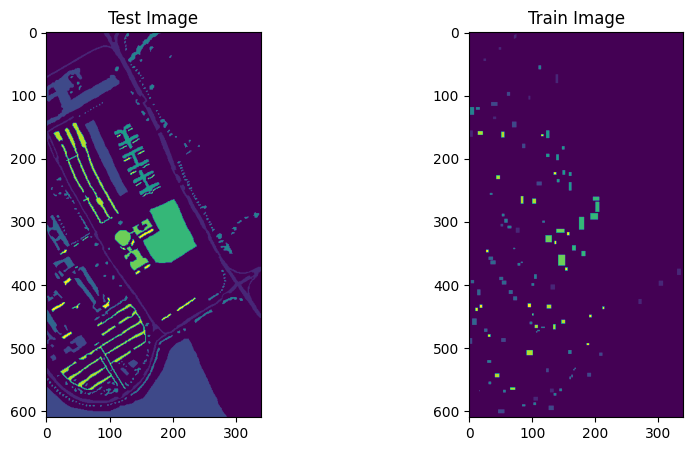

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the images
test_image = Image.open('Test_University.bmp')
train_image = Image.open('Train_University.bmp')

# Display the images
plt.figure(figsize=(10, 5))

# Display the test image
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Test Image")

# Display the train image
plt.subplot(1, 2, 2)
plt.imshow(train_image)
plt.title("Train Image")

plt.show()


In [29]:
train_pixels = np.array(train_image)
test_pixels = np.array(test_image)

labels = np.unique(train_pixels)
labels = labels[labels != 0]

test_labels = np.unique(test_pixels)
test_labels = test_labels[test_labels != 0]

label_pixel_locations = {label: np.column_stack(np.where(train_pixels == label)) for label in labels}
test_label_pixel_locations = {label: np.column_stack(np.where(test_pixels == label)) for label in test_labels}

# Print the number of pixels for each label
for label, locations in label_pixel_locations.items():
    print(f"Label {label} has {len(locations)} pixels.")

for label, locations in test_label_pixel_locations.items():
    print(f"TEST Label {label} has {len(locations)} pixels.")

Label 1 has 548 pixels.
Label 2 has 540 pixels.
Label 3 has 392 pixels.
Label 4 has 524 pixels.
Label 5 has 265 pixels.
Label 6 has 532 pixels.
Label 7 has 375 pixels.
Label 8 has 514 pixels.
Label 9 has 231 pixels.
TEST Label 1 has 6631 pixels.
TEST Label 2 has 18649 pixels.
TEST Label 3 has 2099 pixels.
TEST Label 4 has 3064 pixels.
TEST Label 5 has 1345 pixels.
TEST Label 6 has 5029 pixels.
TEST Label 7 has 1330 pixels.
TEST Label 8 has 3682 pixels.
TEST Label 9 has 947 pixels.


In [30]:
import numpy as np

X_data = []  # To store spectral data patches
y_data = []  # To store corresponding labels

PATCH_SIZE = 7

# Patch size
patch_size = PATCH_SIZE
half_patch = patch_size // 2

# Add padding to the image to avoid boundary issues
padded_pavia_university_pca = np.pad(
    pavia_university_pca, 
    pad_width=((half_patch, half_patch), (half_patch, half_patch), (0, 0)), 
    mode='reflect'
)

# Extract 5x5 patches with spectral bands for each labeled pixel
for label, locations in label_pixel_locations.items():
    for (row, col) in locations:
        # Adjust the coordinates for the padded image
        row_padded = row + half_patch
        col_padded = col + half_patch

        # Extract 5x5 patch centered at (row_padded, col_padded)
        patch = padded_pavia_university_pca[row_padded - half_patch:row_padded + half_patch + 1,
                                           col_padded - half_patch:col_padded + half_patch + 1, :]
        X_data.append(patch)
        y_data.append(label)  # Use the label for this patch

# Convert lists to numpy arrays
X_train = np.array(X_data)
y_train = np.array(y_data)

# Verify shapes
print("X_train shape (patches with spectral bands):", X_train.shape)  # Expected shape: (num_patches, 5, 5, bands)
print("y_train shape (labels):", y_train.shape)  # Expected shape: (num_patches,)


X_train shape (patches with spectral bands): (3921, 7, 7, 4)
y_train shape (labels): (3921,)


In [31]:
unique_labels, label_counts = np.unique(pavia_center_gt, return_counts=True)

# Print the counts for each class
print("Class Distribution in Ground Truth:")
for label, count in zip(unique_labels, label_counts):
    print(f"Class {label}: {count} instances")

Class Distribution in Ground Truth:
Class 0: 744285 instances
Class 1: 7598 instances
Class 2: 9248 instances
Class 3: 2685 instances
Class 4: 7287 instances
Class 5: 2863 instances
Class 6: 3090 instances
Class 7: 6584 instances


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Class mapping for Pavia Center
pavia_center_classes = {
    1: 'Trees',
    2: 'Asphalt',
    3: 'Self-Blocking Bricks',
    4: 'Bitumen',
    5: 'Shadows',
    6: 'Meadows',
    7: 'Bare Soil'
}


def extract_all_patches(ground_truth, image, patch_size=PATCH_SIZE):

    half_patch = patch_size // 2
    X_patches, y_labels = [], []

    # Pad the image to handle edge pixels
    padded_image = np.pad(
        image,
        pad_width=((half_patch, half_patch), (half_patch, half_patch), (0, 0)),
        mode='reflect'
    )

    # Iterate over every pixel in the ground truth
    rows, cols = ground_truth.shape
    for row in range(rows):
        for col in range(cols):
            label = ground_truth[row, col]
            if label != 0:  # Process only labeled pixels (non-zero)
                row_padded = row + half_patch
                col_padded = col + half_patch

                # Extract patch centered at the current pixel
                patch = padded_image[
                    row_padded - half_patch: row_padded + half_patch + 1,
                    col_padded - half_patch: col_padded + half_patch + 1,
                    :
                ]
                X_patches.append(patch)
                y_labels.append(label)

    return np.array(X_patches), np.array(y_labels)

# Call the function
X_test, y_test = extract_all_patches(pavia_center_gt, pavia_center_pca, patch_size)

# Verify shapes
print("X_test shape (test patches):", X_test.shape)
print("y_test shape (test labels):", y_test.shape)

X_test shape (test patches): (39355, 7, 7, 4)
y_test shape (test labels): (39355,)


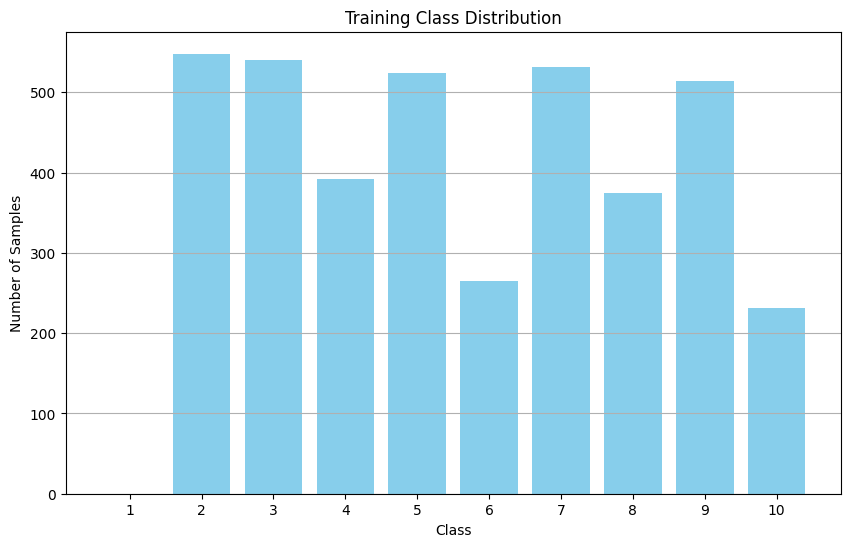

In [33]:
def visualize_class_distribution(class_distribution, class_labels=None, title="Class Distribution"):
    # Set default class labels if none are provided
    if class_labels is None:
        class_labels = range(1, len(class_distribution) + 1)

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_distribution, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(class_labels)
    plt.grid(axis='y')
    plt.show()

# Example usage:
train_class_distribution = np.bincount(y_train.astype(int))
visualize_class_distribution(train_class_distribution, title="Training Class Distribution")

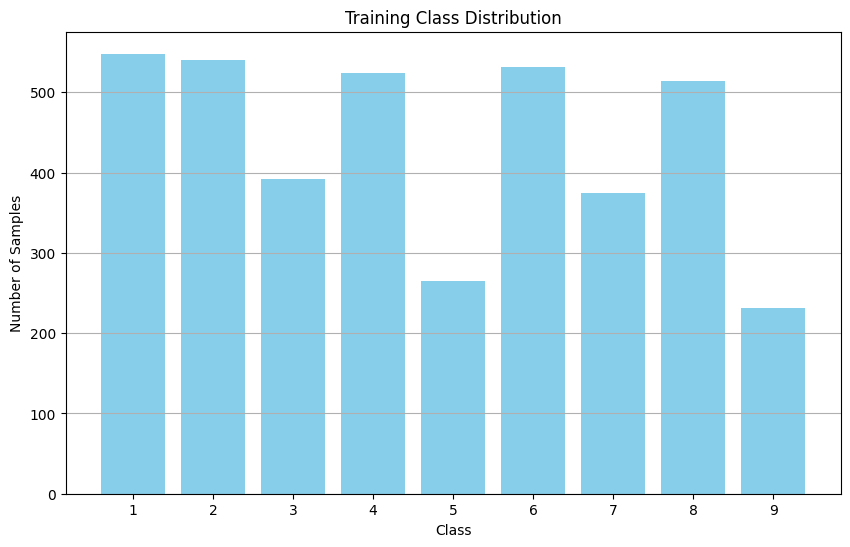

In [34]:
adjusted_labels = y_train - 1  # Subtract 1 to correct the labels

# Count the number of samples for each class after adjustment
class_distribution = np.bincount(adjusted_labels.astype(int))

# Plotting the adjusted class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(class_distribution) + 1), class_distribution, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Training Class Distribution")
plt.xticks(range(1, len(class_distribution) + 1))
plt.grid(axis='y')
plt.show()

In [35]:
# Initialize lists for test data and labels
X_test_uni = []
y_test_uni = []

# Patch size
patch_size = PATCH_SIZE
half_patch = patch_size // 2

# Pad the array to handle edges using reflective padding
padded_image = np.pad(
    pavia_university_pca, 
    pad_width=((half_patch, half_patch), (half_patch, half_patch), (0, 0)), 
    mode='reflect'
)

for label, locations in test_label_pixel_locations.items():
    for (row, col) in locations:
        # Adjust row and col for padding
        row += half_patch
        col += half_patch

        # Extract the 5x5 patch centered at (row, col)
        patch = padded_image[row - half_patch:row + half_patch + 1, 
                             col - half_patch:col + half_patch + 1, :]
        
        # Append the patch to X_test and the label to y_test
        X_test_uni.append(patch)
        y_test_uni.append(label)

# Convert lists to numpy arrays
X_test_uni = np.array(X_test_uni)  # Shape will be (num_samples, 5, 5, bands)
y_test_uni = np.array(y_test_uni)  # Shape will be (num_samples,)

# Print shapes to verify
print("X_test_uni shape:", X_test_uni.shape)  # Expected shape: (num_samples, 5, 5, bands)
print("y_test_uni shape:", y_test_uni.shape)  # Expected shape: (num_samples,)



X_test_uni shape: (42776, 7, 7, 4)
y_test_uni shape: (42776,)


In [36]:
# Example output before shifting
print(f"Original y_train: {np.unique(y_train)}")
print(f"Original y_test: {np.unique(y_test)}")

# Shift labels to start from 0
y_train_shifted = y_train - 1
y_test_shifted = y_test - 1

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train_shifted, num_classes=9)
y_test = to_categorical(y_test_shifted, num_classes=9)

# Print shapes to verify
print("y_train_categorical shape:", y_train.shape)
print("y_test_categorical shape:", y_test.shape)


Original y_train: [1 2 3 4 5 6 7 8 9]
Original y_test: [1 2 3 4 5 6 7]
y_train_categorical shape: (3921, 9)
y_test_categorical shape: (39355, 9)


In [37]:
X_val, X_test_uni, y_val, y_test_uni = train_test_split(
    X_test_uni, y_test_uni, test_size=0.6, random_state=42
)

# Output the shapes for verification
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_uni.shape}, y_test shape: {y_test_uni.shape}")

y_val_shifted = y_val - 1
y_val = to_categorical(y_val_shifted, num_classes=9)



X_val shape: (17110, 7, 7, 4), y_val shape: (17110,)
X_test shape: (25666, 7, 7, 4), y_test shape: (25666,)


In [38]:
def savePreprocessedData(X_trainPatches, X_testPatches, X_valPatches, 
                         y_trainPatches, y_testPatches, y_valPatches, 
                         windowSize, numPCAComponents):
    path = "/kaggle/working/uni_of_pavia_CNN/"
    if not os.path.exists(path):
        os.makedirs(path)

    # Save X_trainPatches
    with open(path + "/Xtrain" + str(windowSize) + "PCA" + str(numPCAComponents) + ".npy", 'bw') as outfile:
        np.save(outfile, X_trainPatches)
    
    # Save X_testPatches
    with open(path + "/Xtest" + str(windowSize) + "PCA" + str(numPCAComponents) + ".npy", 'bw') as outfile:
        np.save(outfile, X_testPatches)
    
    # Save X_valPatches
    with open(path + "/Xval" + str(windowSize) + "PCA" + str(numPCAComponents) + ".npy", 'bw') as outfile:
        np.save(outfile, X_valPatches)
    
    # Save y_trainPatches
    with open(path + "/ytrain" + str(windowSize) + "PCA" + str(numPCAComponents) + ".npy", 'bw') as outfile:
        np.save(outfile, y_trainPatches)
    
    # Save y_testPatches
    with open(path + "/ytest" + str(windowSize) + "PCA" + str(numPCAComponents) + ".npy", 'bw') as outfile:
        np.save(outfile, y_testPatches)
    
    # Save y_valPatches
    with open(path + "/yval" + str(windowSize) + "PCA" + str(numPCAComponents) + ".npy", 'bw') as outfile:
        np.save(outfile, y_valPatches)


numComponents=4
windowSize = 7

savePreprocessedData(X_train, X_test, X_val, 
                     y_train, y_test, y_val, 
                     windowSize=windowSize, numPCAComponents=numComponents)


In [39]:
input_shape = X_train.shape[1:]
input_shape

(7, 7, 4)

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Add, Concatenate
from tensorflow.keras.models import Model

class MorphologicalDilation(tf.keras.layers.Layer):
    def __init__(self, kernel_size, strides=(1, 1), padding='SAME', groups=1, **kwargs):
        super(MorphologicalDilation, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.strides = (strides, strides) if isinstance(strides, int) else strides
        self.padding = padding.upper()
        self.groups = groups

    def build(self, input_shape):
        #print(f"value of input_shape: {input_shape}")
        channels = input_shape[-1]
        if channels % self.groups != 0:
            raise ValueError("The number of input channels must be divisible by groups")
        group_channels = channels // self.groups
        #print(f"value of channels: {channels}")
        #print(f"value of self.groups: {self.groups}")
        #print(f"group channel {group_channels}")

        # Define a fixed structuring element (non-trainable)
        self.kernel = self.add_weight(
            shape=(self.kernel_size[0], self.kernel_size[1], group_channels),  # [H, W, C/g, 1]
            initializer="ones",
            trainable=True,
            name="dilation_kernel"
        )

    def call(self, x):
        def process_sample(sample):
            # Split input tensor along the channel axis into groups
            sample_split = tf.split(sample, num_or_size_splits=self.groups, axis=-1)
            #print(f"Kernel size must be shape 3, kernel size: {self.kernel.shape}")

            # Process each group
            dilated = []
            for group in sample_split:
                # Apply dilation
                dilated_group = tf.nn.dilation2d(
                    input=tf.expand_dims(group, axis=0),  # Add batch dimension temporarily
                    filters=self.kernel,
                    strides=[1, *self.strides, 1],
                    padding=self.padding,
                    data_format="NHWC",
                    dilations=[1, 1, 1, 1]
                )
                dilated.append(tf.squeeze(dilated_group, axis=0))  # Remove batch dimension after processing

            # Concatenate the groups back together
            return tf.concat(dilated, axis=-1)

        # Infer dynamic output shape by processing a dummy input
        dummy_input = tf.zeros_like(x[0])  # Use the first sample from the batch to infer output shape
        sample_output = process_sample(dummy_input)
        inferred_output_shape = sample_output.shape.as_list()  # Convert to list for use in TensorSpec

        # Use tf.map_fn to process each sample in the batch
        processed_batch = tf.map_fn(
            process_sample,
            x,
            fn_output_signature=tf.TensorSpec(
                shape=[None] + inferred_output_shape[1:],  # Dynamic batch size, static spatial dimensions
                dtype=tf.float32
            )
        )

        return processed_batch


    def compute_output_shape(self, input_shape):
        if self.padding == "SAME":
            return input_shape
        elif self.padding == "VALID":
            height = (input_shape[1] - self.kernel_size[0]) // self.strides[0] + 1
            width = (input_shape[2] - self.kernel_size[1]) // self.strides[1] + 1
            return (input_shape[0], height, width, input_shape[-1])


class MorphologicalErosion(tf.keras.layers.Layer):
    def __init__(self, kernel_size, strides=(1, 1), padding='SAME', groups=1, **kwargs):
        super(MorphologicalErosion, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.strides = (strides, strides) if isinstance(strides, int) else strides
        self.padding = padding.upper()
        self.groups = groups

    def build(self, input_shape):
        channels = input_shape[-1]
        if channels % self.groups != 0:
            raise ValueError("The number of input channels must be divisible by groups")
        group_channels = channels // self.groups

        # Define a fixed structuring element (non-trainable)
        self.kernel = self.add_weight(
            shape=(self.kernel_size[0], self.kernel_size[1], group_channels),  # [H, W, C/g, 1]
            initializer="ones",
            trainable=True,
            name="erosion_kernel"
        )

    def call(self, x):
        def process_sample(sample):
            # Split input tensor along the channel axis into groups
            sample_split = tf.split(sample, num_or_size_splits=self.groups, axis=-1)
            #print(f"Kernel size must be shape 3, kernel size: {self.kernel.shape}")

            # Process each group
            eroded = []
            for group in sample_split:
                # Apply dilation
                eroded_group = tf.nn.erosion2d(
                    tf.expand_dims(group, axis=0),  # Add batch dimension temporarily
                    filters=self.kernel,
                    strides=[1, *self.strides, 1],
                    padding=self.padding,
                    data_format="NHWC",
                    dilations=[1, 1, 1, 1]
                )
                eroded.append(tf.squeeze(eroded_group, axis=0))  # Remove batch dimension after processing

            # Concatenate the groups back together
            return tf.concat(eroded, axis=-1)

        # Infer dynamic output shape by processing a dummy input
        dummy_input = tf.zeros_like(x[0])  # Use the first sample from the batch to infer output shape
        sample_output = process_sample(dummy_input)
        inferred_output_shape = sample_output.shape.as_list()  # Convert to list for use in TensorSpec

        # Use tf.map_fn to process each sample in the batch
        processed_batch = tf.map_fn(
            process_sample,
            x,
            fn_output_signature=tf.TensorSpec(
                shape=[None] + inferred_output_shape[1:],  # Dynamic batch size, static spatial dimensions
                dtype=tf.float32
            )
        )

        return processed_batch


    def compute_output_shape(self, input_shape):
        if self.padding == "SAME":
            return input_shape
        elif self.padding == "VALID":
            height = (input_shape[1] - self.kernel_size[0]) // self.strides[0] + 1
            width = (input_shape[2] - self.kernel_size[1]) // self.strides[1] + 1
            return (input_shape[0], height, width, input_shape[-1])
        

In [41]:
"""
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense


# Define all combinations
combinations = [
    ["dilation"],  # Only dilation after convolutions
    ["erosion"],  # Only erosion after convolutions
    ["dilation", "erosion"],  # Dilation followed by erosion
    ["erosion", "dilation"],  # Erosion followed by dilation
]

# Function to create models with given combination
def create_model_with_layers(combination, kernel_size=(3, 3)):
    model = Sequential([
        # Block 1: Convolutional Layer
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(7, 7, 4), padding='same'),
        *([MorphologicalDilation(kernel_size=kernel_size)] if "dilation" in combination else []),
        *([MorphologicalErosion(kernel_size=kernel_size)] if "erosion" in combination else []),

        # Block 2: Convolutional Layer
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        *([MorphologicalDilation(kernel_size=kernel_size)] if "dilation" in combination else []),
        *([MorphologicalErosion(kernel_size=kernel_size)] if "erosion" in combination else []),

        # Block 3: Convolutional Layer
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        *([MorphologicalDilation(kernel_size=kernel_size)] if "dilation" in combination else []),
        *([MorphologicalErosion(kernel_size=kernel_size)] if "erosion" in combination else []),

        # Global Average Pooling
        GlobalAveragePooling2D(),

        # Dense Layer
        Dense(128, activation='relu'),

        # Fully Connected Layer (Output)
        Dense(9, activation='softmax')
    ])
    return model

# Create and summarize models for all combinations
for i, combination in enumerate(combinations):
    print(f"Testing model with combination: {combination}")
    model = create_model_with_layers(combination)
    model.summary()
    print("\n" + "="*50 + "\n")
"""

'\nimport tensorflow as tf\nfrom tensorflow.keras import Sequential\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense\n\n\n# Define all combinations\ncombinations = [\n    ["dilation"],  # Only dilation after convolutions\n    ["erosion"],  # Only erosion after convolutions\n    ["dilation", "erosion"],  # Dilation followed by erosion\n    ["erosion", "dilation"],  # Erosion followed by dilation\n]\n\n# Function to create models with given combination\ndef create_model_with_layers(combination, kernel_size=(3, 3)):\n    model = Sequential([\n        # Block 1: Convolutional Layer\n        Conv2D(filters=32, kernel_size=(3, 3), activation=\'relu\', input_shape=(7, 7, 4), padding=\'same\'),\n        *([MorphologicalDilation(kernel_size=kernel_size)] if "dilation" in combination else []),\n        *([MorphologicalErosion(kernel_size=kernel_size)] if "erosion" in combination else []),\n\n        # Block 2: Convolutional Layer\n       

In [42]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense


model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(7, 7, 4), activation='relu'),
    #MorphologicalDilation(kernel_size=(3, 3)),  # Morphological dilation with kernel size (3, 3)
       
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    #MorphologicalErosion(kernel_size=(3, 3)),  # Morphological erosion with kernel size (3, 3)
    
    
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    #MorphologicalDilation(kernel_size=(3, 3)),  # Morphological dilation with kernel size (3, 3)
    
    
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

c:\Users\msı\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1) 
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 0.7950121654501217, 1: 0.8067901234567901, 2: 1.1113945578231292, 3: 0.8314249363867684, 4: 1.6440251572327045, 5: 0.818922305764411, 6: 1.1617777777777778, 7: 0.8476005188067445, 8: 1.886002886002886}


In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
] #### VALIDATIONU UNIVERSITY 

optimizer = Adam(learning_rate=0.0001) 

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), class_weight=class_weights_dict, epochs=100, batch_size=32, callbacks=callbacks)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2256 - loss: 2.0961 - val_accuracy: 0.2648 - val_loss: 1.6671
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5902 - loss: 1.1232 - val_accuracy: 0.5613 - val_loss: 0.9745
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6955 - loss: 0.6801 - val_accuracy: 0.6073 - val_loss: 0.8529
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7192 - loss: 0.5818 - val_accuracy: 0.6418 - val_loss: 0.7815
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7386 - loss: 0.5245 - val_accuracy: 0.6724 - val_loss: 0.7222
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7607 - loss: 0.4830 - val_accuracy: 0.6980 - val_loss: 0.6811
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7776 - loss: 0.4522 - val_accuracy: 0.7232 - val_loss: 0.6496
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7866 - loss: 0.4278 - 

In [45]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#import spectral

def reports(X_test,y_test):

    labels = list(range(7))  # [0, 1, 2, ..., 8]

    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = [
        'Trees',                 # Class 1 
        'Asphalt',               # Class 2
        'Self-Blocking Bricks',  # Class 3
        'Bitumen',               # Class 4
        'Shadows',               # Class 5
        'Meadows',               # Class 6
        'Bare Soil'              # Class 7
    ]

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, labels=labels, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=labels)
    score = model.evaluate(X_test, y_test, batch_size=256)
    test_Loss =  score[0]*100
    test_accuracy = score[1]*100
    return classification, confusion, test_Loss, test_accuracy

In [46]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    print(f'Found directory: {dirname}')
    for filename in filenames:
        print(os.path.join(dirname, filename))

Found directory: /kaggle/working
Found directory: /kaggle/working\uni_of_pavia_CNN
/kaggle/working\uni_of_pavia_CNN\Xtest7PCA4.npy
/kaggle/working\uni_of_pavia_CNN\Xtrain7PCA4.npy
/kaggle/working\uni_of_pavia_CNN\Xval7PCA4.npy
/kaggle/working\uni_of_pavia_CNN\ytest7PCA4.npy
/kaggle/working\uni_of_pavia_CNN\ytrain7PCA4.npy
/kaggle/working\uni_of_pavia_CNN\yval7PCA4.npy


In [ ]:
X_test=np.load("/kaggle/working/uni_of_pavia_CNN/Xtest7PCA4.npy")
y_test=np.load("/kaggle/working/uni_of_pavia_CNN/ytest7PCA4.npy")

print(X_test.shape)

(39355, 7, 7, 4)


In [ ]:
classification, confusion, test_loss, test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
print("Classification:")
print(classification)
print("Test loss: "+str(test_loss)+" %")
print("Test accuracy: "+str(test_accuracy)+" %")

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.0967 - loss: 18.6263
Classification:
                      precision    recall  f1-score   support

               Trees       0.00      0.00      0.00      7598
             Asphalt       0.09      0.07      0.08      9248
Self-Blocking Bricks       0.00      0.00      0.00      2685
             Bitumen       0.00      0.00      0.00      7287
             Shadows       0.00      0.00      0.00      2863
             Meadows       0.37      0.69      0.49      3090
           Bare Soil       0.00      0.00      0.00      6584

           micro avg       0.08      0.07      0.07     39355
           macro avg       0.07      0.11      0.08     39355
        weighted avg       0.05      0.07      0.06     39355

Test loss: 1932.9744338989258 %
Test accuracy: 7.150298357009888 %


In [50]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def reports_pavia_uni(X_test_uni, y_test_uni, model):
    # Adjust labels and target names for Pavia University dataset
    labels = list(range(9))  # Classes [0, 1, ..., 8]

    # Target names for Pavia University classes
    target_names = [
        'Asphalt',                # Class 1
        'Meadows',                # Class 2
        'Gravel',                 # Class 3
        'Trees',                  # Class 4
        'Painted Metal Sheets',   # Class 5
        'Bare Soil',              # Class 6
        'Bitumen',                # Class 7
        'Self-Blocking Bricks',   # Class 8
        'Shadows'                 # Class 9
    ]

    # Generate predictions
    Y_pred = model.predict(X_test_uni)
    y_pred = np.argmax(Y_pred, axis=1)  # Predicted labels

    # Ensure the model is compiled before evaluation
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Classification report
    classification = classification_report(np.argmax(y_test_uni, axis=1), y_pred, labels=labels, target_names=target_names)

    # Confusion matrix
    confusion = confusion_matrix(np.argmax(y_test_uni, axis=1), y_pred, labels=labels)

    # Model evaluation
    score = model.evaluate(X_test_uni, y_test_uni, batch_size=256)
    test_loss = score[0] * 100
    test_accuracy = score[1] * 100

    return classification, confusion, test_loss, test_accuracy


In [56]:
y_test_uni.shape
y_test_uni_shifted = y_test_uni - 1 
y_test_uni = to_categorical(y_test_uni_shifted, num_classes=9)

In [57]:

classification, confusion, test_loss, test_accuracy = reports_pavia_uni(X_test_uni,y_test_uni, model)
classification = str(classification)
confusion = str(confusion)
print("Classification:")
print(classification)
print("Test loss: "+str(test_loss)+" %")
print("Test accuracy: "+str(test_accuracy)+" %")

803/803 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8162 - loss: 0.5557
Classification:
                      precision    recall  f1-score   support

             Asphalt       0.94      0.79      0.86      3995
             Meadows       0.88      0.86      0.87     11146
              Gravel       0.58      0.73      0.65      1244
               Trees       0.67      0.97      0.79      1820
Painted Metal Sheets       0.98      0.95      0.96       818
           Bare Soil       0.67      0.55      0.61      2997
             Bitumen       0.64      0.77      0.70       814
Self-Blocking Bricks       0.79      0.88      0.84      2262
             Shadows       1.00      0.92      0.96       570

            accuracy                           0.82     25666
           macro avg       0.80      0.82      0.80     25666
        weighted avg       0.83      0.82      0.82     25666

Test loss: 55.446189641952515 %
Test accuracy: 81.67225122